# Imports, styles, etc

In [1]:
import numpy as np
import pandas as pd
from liwc import Liwc
from matplotlib import pyplot as plt
import seaborn as sns
import json
from tqdm import tqdm
import scipy
import glob
import re
import yaml
import warnings
warnings.filterwarnings("ignore")
tqdm.pandas()

import scipy.stats as stats

filepaths = yaml.safe_load(open("../../config/filepaths.yaml"))

import sys
sys.path.append(filepaths['utils'])
from data import *
from liwc_utils import *
from analisys import *

In [2]:
plt.rcParams['axes.labelsize']  = 14 # fontes no tamanho usado no template
plt.rcParams['axes.titlesize']  = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['font.family'] = 'serif'
# plt.rcParams['text.usetex'] = True
plt.rcParams['lines.linewidth'] = 1.5

plt.style.use('tableau-colorblind10') # use um estilo colorblind!
plt.ion()

---

In [22]:
DATASET = 'twitter' # 'coraal-buckeye' | 'twitter' | 'youtube' | 'interview'

data = load_dataset(DATASET)
data.head(1)

,text,perspective_score,flair_score,textblob_score,vader_score,detoxify_original_score,detoxify_unbiased_score,detoxify_multilingual_score,has_swearing,file,group
0,@user wat r u doin boy,0.037538,0.0,0.0,0.0,0.048113,0.014581,0.146005,False,aa_112.csv,aa


# Reading and processing data

In [23]:
#Numero de amostras de cada tipo
data.drop_duplicates('file').groupby('group').count()['text']

group
aa    250
wh    250
Name: text, dtype: int64

In [6]:
# Faz copia dos dados e remove qualquer caracter que não seja textual ou apóstrofo
df = data.copy()
df['text'] = df['text'].apply(lambda x: re.sub("[^\w\d'\s]+",'',x))

In [7]:
# executes a join in column text grouped by file, this will join all the texts and keep group info
text_df = df.groupby('file',as_index=False).agg({
    'text': lambda x: ' '.join(x),
    'group': lambda x: x.iloc[0]
})
text_df.head(3)

,file,text,group
0,black-f-alexis mcgill johnson,Implicit bias is our brains' automatic process...,Black Woman
1,black-f-alondra nelson,As a very young girl it became clear that I wa...,Black Woman
2,black-f-alysia montano,We're not paid a huge salary by a league at al...,Black Woman


In [8]:
liwc_parser = Liwc(filepaths['liwc_dict']) # carrega o dicionário e inicializa a classe do LIWC

text_df['liwc_count'] = text_df['text'].apply(liwc_sentence_parse, args=(liwc_parser,)) #aplica do liwc
text_df = text_df.reset_index(drop=True)
text_df.head(3)

,file,text,group,liwc_count
0,black-f-alexis mcgill johnson,Implicit bias is our brains' automatic process...,Black Woman,"{'function': 230, 'auxverb': 47, 'verb': 77, '..."
1,black-f-alondra nelson,As a very young girl it became clear that I wa...,Black Woman,"{'function': 467, 'article': 67, 'adverb': 42,..."
2,black-f-alysia montano,We're not paid a huge salary by a league at al...,Black Woman,"{'function': 333, 'negate': 11, 'cogproc': 60,..."


---

# Processing data with LIWC

In [9]:
# create a new dataset where the dicts inside liwc_cont are expanded in columns
liwc_df = pd.concat([text_df.drop(['liwc_count'], axis=1), text_df['liwc_count'].apply(pd.Series)], axis=1)
liwc_df = liwc_df.fillna(0)

#normalizing 
liwc_df_norm = (liwc_df[liwc_parser.categories.values()].T * ( 1 / liwc_df[liwc_parser.categories.values()].sum(axis=1) )).T
liwc_df_norm.reset_index(drop=True,inplace=True)

liwc_df_norm['group'] = text_df['group']
liwc_df_norm = liwc_df_norm.fillna(0)
liwc_df_norm.head(3)

,function,pronoun,ppron,i,we,you,shehe,they,ipron,article,...,money,relig,death,informal,swear,netspeak,assent,nonflu,filler,group
0,0.181675,0.060032,0.033965,0.000790,0.022907,0.007109,0.000000,0.003160,0.026066,0.016588,...,0.000790,0.000000,0.0,0.001580,0.0,0.0,0.001580,0.000000,0.0,Black Woman
1,0.195316,0.051861,0.027185,0.006692,0.002509,0.007528,0.006692,0.003764,0.024676,0.028022,...,0.001255,0.000836,0.0,0.000836,0.0,0.0,0.000000,0.000836,0.0,Black Woman
2,0.194509,0.052570,0.028037,0.008178,0.005257,0.007593,0.004673,0.002336,0.024533,0.020444,...,0.004089,0.000000,0.0,0.001168,0.0,0.0,0.000584,0.000000,0.0,Black Woman


---

## Kruscal-Wallis Test

In [10]:
experiments = []
old_experiments = []

for feature in liwc_parser.categories.values():
    
    result = stats.kruskal(
        liwc_df_norm[liwc_df_norm.group=='White Man'][feature],
        liwc_df_norm[liwc_df_norm.group=='White Woman'][feature],
        liwc_df_norm[liwc_df_norm.group=='Black Man'][feature],
        liwc_df_norm[liwc_df_norm.group=='Black Woman'][feature],
    )
    experiments.append({
        'feature': feature,
        'statistic': result[0],
        'pvalue': result[1]
    })
experiments = pd.DataFrame(experiments)

## Relevant features

https://www.liwc.net/LIWC2007LanguageManual.pdf

https://repositories.lib.utexas.edu/bitstream/handle/2152/31333/LIWC2015_LanguageManual.pdf

In [11]:
import statsmodels.stats.multitest as smt
idx = smt.multipletests(pvals=experiments.pvalue, alpha=0.01, method="bonferroni")[0]
print(len(experiments[idx].sort_values('pvalue')))
experiments[idx].sort_values('pvalue')

0


,feature,statistic,pvalue


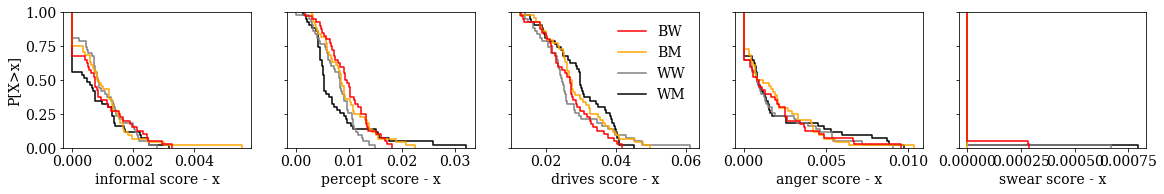

In [12]:
ploting_vars = ['informal','percept','drives','anger','swear']

fig, axes = plt.subplots(1, 5,sharey=True,sharex=False,figsize=(16,2.8))
axes = axes.ravel()

for i,var in enumerate(ploting_vars): 
    if i==2:
        g = sns.ecdfplot(
            liwc_df_norm, 
            x=var, 
            hue="group",
            complementary=True, 
            ax=axes[i],
            legend=True,
            hue_order=['Black Woman','Black Man','White Woman', 'White Man'],
            palette=['red','orange','grey','black']
        ) 
        g.legend_.set_title(None)
        new_labels = ['BW', 'BM','WW','WM']
        for t, l in zip(g.legend_.texts, new_labels):
            t.set_text(l)
        g.legend_.set_frame_on(False)
        g.legend_.set_frame_on(False)
    else:
        sns.ecdfplot(
            liwc_df_norm, 
            x=var, 
            hue="group",
            complementary=True, 
            ax=axes[i],
            legend=False, 
            hue_order=['Black Woman','Black Man','White Woman', 'White Man'],
            palette=['red','orange','grey','black']
        )
    axes[i].set(ylabel='P[X>x]',xlabel='%s score - x'%var)
    # axes[i].set(yscale='log')

fig.tight_layout()
# plt.savefig('liwc_dists.pdf')
plt.show()


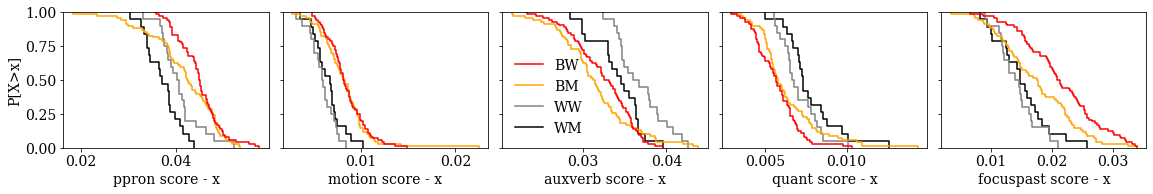

In [21]:
i = 5
ploting_vars = list(experiments.sort_values('pvalue').iloc[i:i+5].feature)

fig, axes = plt.subplots(1, 5,sharey=True,sharex=False,figsize=(16,2.8))
axes = axes.ravel()

for i,var in enumerate(ploting_vars): 
    if i==2:
        g = sns.ecdfplot(
            liwc_df_norm, 
            x=var, 
            hue="group",
            complementary=True, 
            ax=axes[i],
            legend=True,
            hue_order=['Black Woman','Black Man','White Woman', 'White Man'],
            palette=['red','orange','grey','black']
        ) 
        g.legend_.set_title(None)
        new_labels = ['BW', 'BM','WW','WM']
        for t, l in zip(g.legend_.texts, new_labels):
            t.set_text(l)
        g.legend_.set_frame_on(False)
        g.legend_.set_frame_on(False)
    else:
        sns.ecdfplot(
            liwc_df_norm, 
            x=var, 
            hue="group",
            complementary=True, 
            ax=axes[i],
            legend=False, 
            hue_order=['Black Woman','Black Man','White Woman', 'White Man'],
            palette=['red','orange','grey','black']
        )
    axes[i].set(ylabel='P[X>x]',xlabel='%s score - x'%var)
    # axes[i].set(yscale='log')

fig.tight_layout()
# plt.savefig('liwc_dists.pdf')
plt.show()


# individual categories analisys

### calculating liwc per sentence

In [30]:
scores_liwc = df.copy()

scores_liwc['liwc_count'] = scores_liwc['text'].apply(liwc_sentence_parse, args=(liwc_parser,)) #aplica do liwc
scores_liwc['len'] = scores_liwc.text.str.split(' ').str.len()
scores_liwc = scores_liwc.reset_index().rename(columns={'index':'sentence_id'})
scores_liwc.head()

,sentence_id,text,perspective_score,flair_score,textblob_score,vader_score,detoxify_original_score,detoxify_unbiased_score,detoxify_multilingual_score,has_swearing,file,group,liwc_count,len
0,0,text mmhm yes um ivory city northeast ivory ci...,0.046122,0.789697,0.375000,0.0,0.000628,0.000439,0.000305,False,DCB_se1_ag4_f_01_1.txt,Black Woman,"{'informal': 5, 'assent': 3, 'nonflu': 2, 'rel...",20
1,1,montello avenue mmhm over there all my life cr...,0.091189,0.086629,0.375000,0.0,0.023772,0.001595,0.006032,False,DCB_se1_ag4_f_01_1.txt,Black Woman,"{'relativ': 2, 'space': 2, 'informal': 2, 'ass...",13
2,2,no that was my elementary school um crummell n...,0.039942,0.999234,0.187500,0.0,0.002245,0.000864,0.001894,False,DCB_se1_ag4_f_01_1.txt,Black Woman,"{'function': 5, 'negate': 1, 'pronoun': 3, 'ip...",12
3,3,mmhm they done tore it down but the building i...,0.070916,0.822410,0.472222,0.0,0.000837,0.000396,0.001230,False,DCB_se1_ag4_f_01_1.txt,Black Woman,"{'informal': 1, 'assent': 1, 'function': 9, 'p...",12
4,4,mmhm no he was born in um,0.046465,0.998983,0.375000,0.0,0.001034,0.000635,0.000560,False,DCB_se1_ag4_f_01_1.txt,Black Woman,"{'informal': 2, 'assent': 1, 'function': 4, 'n...",7


In [31]:
# sentences_liwc_counts_scored 
sentences_liwc_counts_scored = liwc_df_norm.reset_index(drop=False).rename(columns={'index':'sentence_id'})
sentences_liwc_counts_scored = sentences_liwc_counts_scored.merge(scores_liwc[[i for i in scores_liwc.columns if 'score' in i]+['sentence_id']], on='sentence_id')
sentences_liwc_counts_scored.head()

,sentence_id,function,pronoun,ppron,i,we,you,shehe,they,ipron,...,nonflu,filler,group,perspective_score,flair_score,textblob_score,vader_score,detoxify_original_score,detoxify_unbiased_score,detoxify_multilingual_score
0,0,0.175233,0.066789,0.044761,0.021886,0.002542,0.009884,0.005366,0.005083,0.022028,...,0.004518,0.0,Black Woman,0.046122,0.789697,0.375,0.000,0.000628,0.000439,0.000305
1,0,0.175233,0.066789,0.044761,0.021886,0.002542,0.009884,0.005366,0.005083,0.022028,...,0.004518,0.0,Black Woman,0.028267,0.975777,0.500,0.000,0.000658,0.000594,0.000292
2,0,0.175233,0.066789,0.044761,0.021886,0.002542,0.009884,0.005366,0.005083,0.022028,...,0.004518,0.0,Black Woman,0.047839,0.997037,0.500,0.000,0.000603,0.000656,0.000473
3,0,0.175233,0.066789,0.044761,0.021886,0.002542,0.009884,0.005366,0.005083,0.022028,...,0.004518,0.0,Black Woman,0.056532,0.999531,0.465,0.072,0.000633,0.000495,0.000525
4,0,0.175233,0.066789,0.044761,0.021886,0.002542,0.009884,0.005366,0.005083,0.022028,...,0.004518,0.0,Black Woman,0.010274,0.988794,0.500,0.000,0.001047,0.000563,0.000291


KeyError: 'pop from an empty set'

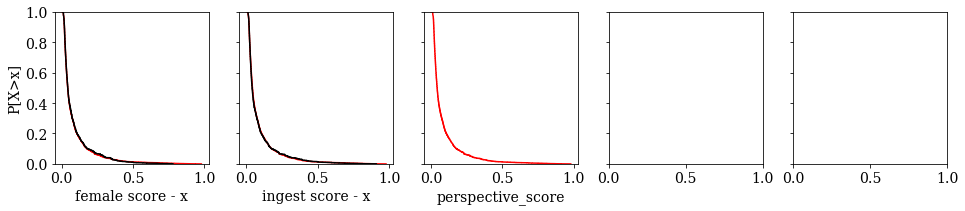

In [32]:
ploting_vars = ['female','ingest','i','family','male']

for score in [i for i in scores_liwc.columns if 'score' in i]:
    fig, axes = plt.subplots(1, 5,sharey=True,sharex=False,figsize=(16,2.8))
    axes = axes.ravel()

    for i,var in enumerate(ploting_vars):
        if i==2:
            g2 = sns.ecdfplot(sentences_liwc_counts_scored[sentences_liwc_counts_scored[var]>0][score], complementary=True,ax=axes[i],legend=True, color='red')
            g1 = sns.ecdfplot(sentences_liwc_counts_scored[sentences_liwc_counts_scored[var]==0][score], complementary=True,ax=axes[i],legend=True,color='black')
            
    #         break
            g2.legend(['with','without'])
            g1.legend_.set_title(None)
            
            new_labels = ['with','without']
            for t, l in zip(g.legend_.texts, new_labels):
                t.set_text(l)
            g2.legend_.set_frame_on(False)
            g2.legend_.set_frame_on(False)
            
        else:
            sns.ecdfplot(sentences_liwc_counts_scored[sentences_liwc_counts_scored[var]>0][score], complementary=True,ax=axes[i],legend=False,color='red')
            g1 = sns.ecdfplot(sentences_liwc_counts_scored[sentences_liwc_counts_scored[var]==0][score], complementary=True,ax=axes[i],legend=False,color='black')
            

        axes[i].set(ylabel='P[X>x]',xlabel='%s score - x'%var)

    fig.tight_layout()
    # plt.savefig('liwc_toxicity_dists.pdf')
    plt.show()



### KS test and bonferroni correction

In [19]:
liwc_toxicity_experiments = []
for feature in ploting_vars:
    
    result = stats.ks_2samp(
        sentences_liwc_counts_scored[sentences_liwc_counts_scored[feature]==0].score,
        sentences_liwc_counts_scored[sentences_liwc_counts_scored[feature]>0].score
    )
    liwc_toxicity_experiments.append({
        'feature': feature,
        'statistic': result[0],
        'pvalue': result[1]
    })
liwc_toxicity_experiments = pd.DataFrame(liwc_toxicity_experiments)
liwc_toxicity_experiments

,feature,statistic,pvalue
0,quant,0.045881,5.254759e-22
1,pronoun,0.126690,3.692351e-39
2,informal,0.099188,2.321264e-61
3,adj,0.010466,9.924000e-02
4,netspeak,0.110875,4.392570e-22


In [20]:
idx_tox = smt.multipletests(pvals=liwc_toxicity_experiments.pvalue, alpha=0.01, method="bonferroni")[0]
print(len(liwc_toxicity_experiments[idx_tox].sort_values('pvalue')))
liwc_toxicity_experiments[idx_tox].sort_values('pvalue')

4


,feature,statistic,pvalue
2,informal,0.099188,2.321264e-61
1,pronoun,0.126690,3.692351e-39
4,netspeak,0.110875,4.392570e-22
0,quant,0.045881,5.254759e-22


---

# Avg. words per video

In [46]:
scores_liwc.groupby(['file','group']).sum()[['len']].reset_index().groupby('group').mean()

,len
group,
Black Man,732.772727
Black Woman,655.025000
White Man,545.976744
White Woman,620.720930
